In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix

In [2]:
# Load dataset
df = pd.read_csv("dataset_med.csv")

In [3]:
df.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [4]:
df.shape

(890000, 17)

In [5]:
df.isnull().sum()

id                    0
age                   0
gender                0
country               0
diagnosis_date        0
cancer_stage          0
family_history        0
smoking_status        0
bmi                   0
cholesterol_level     0
hypertension          0
asthma                0
cirrhosis             0
other_cancer          0
treatment_type        0
end_treatment_date    0
survived              0
dtype: int64

In [6]:
df.drop(columns=['id'], inplace=True)

In [7]:
# 1. Convert date columns to datetime
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])
df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'])

In [8]:
# 2. Feature: Treatment duration in days
df['treatment_duration'] = (df['end_treatment_date'] - df['diagnosis_date']).dt.days


In [9]:
# 3. Feature: Extract year and month of diagnosis
df['diagnosis_year'] = df['diagnosis_date'].dt.year
df['diagnosis_month'] = df['diagnosis_date'].dt.month

In [10]:
# Drop original date columns after extracting features
df.drop(columns=['diagnosis_date', 'end_treatment_date'], inplace=True)


In [11]:
# 4. Encode 'survived' (target column) to binary (0 = No, 1 = Yes)
df['survived'] = df['survived'].map({'No': 0, 'Yes': 1, 0: 0, 1: 1})  # supports both string/number

In [12]:
# 5. Convert Yes/No binary columns to 0/1
binary_cols = ['family_history', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer']
for col in binary_cols:
    df[col] = df[col].map({'No': 0, 'Yes': 1, 0: 0, 1: 1})

In [13]:
# 6. One-hot encode categorical variables (drop_first=True to avoid dummy trap)
categorical_cols = ['gender', 'country', 'cancer_stage', 'smoking_status', 'treatment_type']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [14]:
df.head()

,age,family_history,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived,treatment_duration,...,country_Sweden,cancer_stage_Stage II,cancer_stage_Stage III,cancer_stage_Stage IV,smoking_status_Former Smoker,smoking_status_Never Smoked,smoking_status_Passive Smoker,treatment_type_Combined,treatment_type_Radiation,treatment_type_Surgery
0,64.0,1,29.4,199,0,0,1,0,0,523,...,True,False,False,False,False,False,True,False,False,False
1,50.0,1,41.2,280,1,1,0,0,1,424,...,False,False,True,False,False,False,True,False,False,True
2,65.0,1,44.0,268,1,1,0,0,0,370,...,False,False,True,False,True,False,False,True,False,False
3,51.0,0,43.0,241,1,1,0,0,0,443,...,False,False,False,False,False,False,True,False,False,False
4,37.0,0,19.7,178,0,0,0,0,0,406,...,False,False,False,False,False,False,True,True,False,False


In [15]:
df.shape

(890000, 48)

In [16]:
df = df.astype(int)

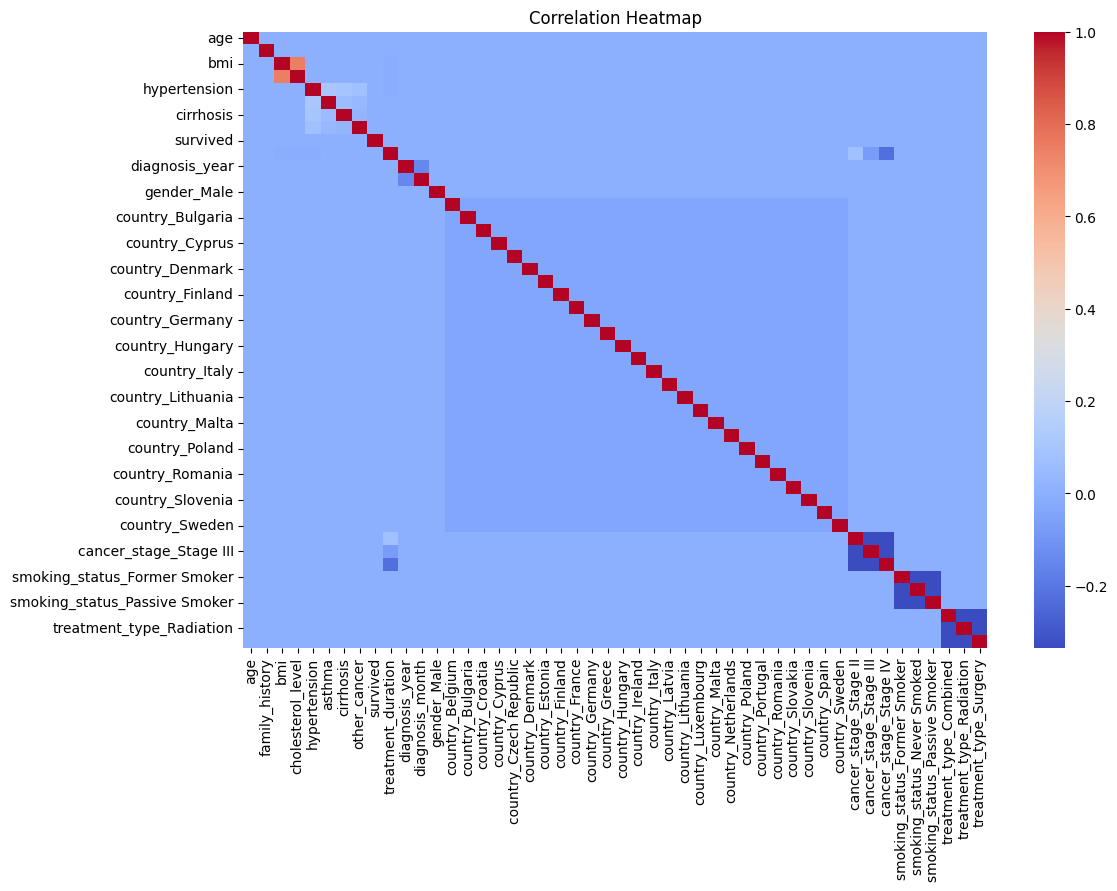

In [17]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


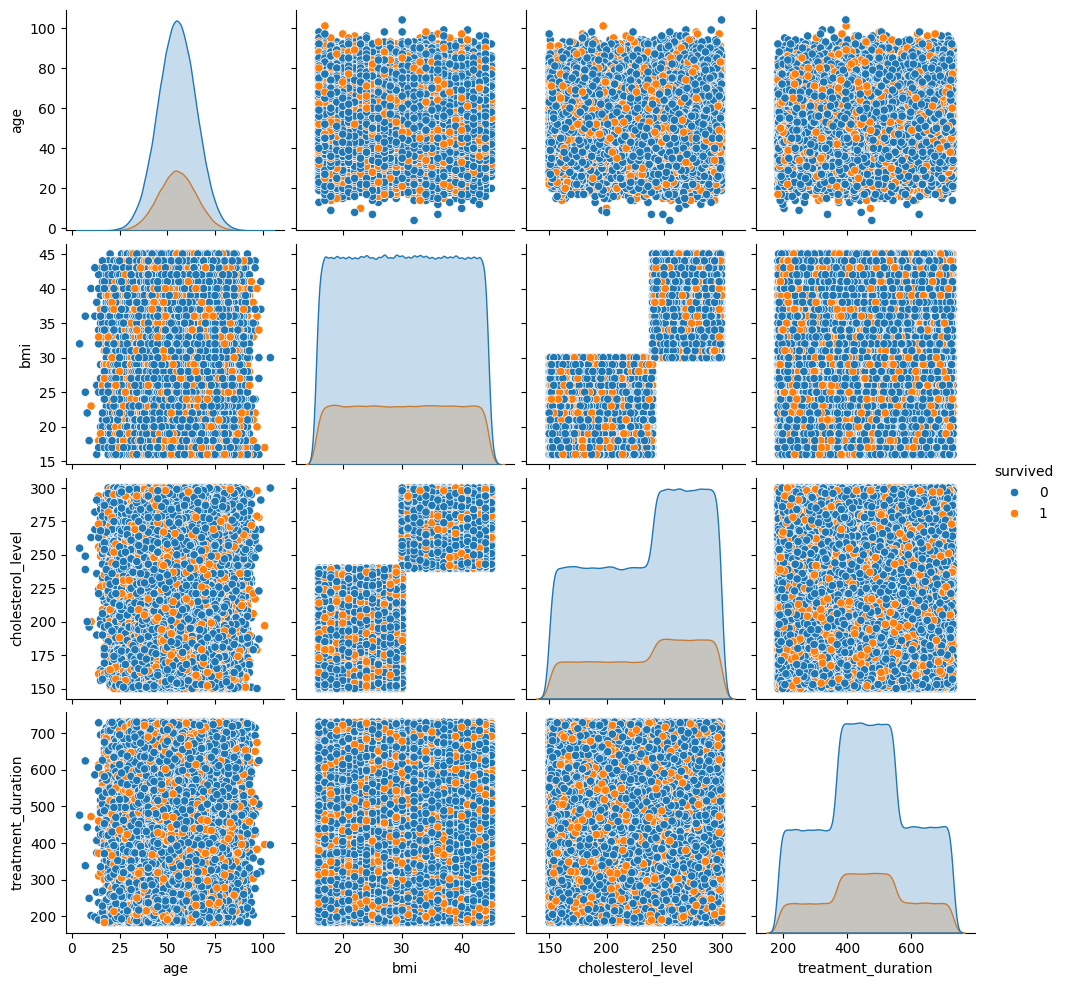

In [18]:
# Pairplot for some key numeric features and target
sns.pairplot(df[['age', 'bmi', 'cholesterol_level', 'treatment_duration', 'survived']], hue='survived')
plt.show()

In [19]:
# Prepare data for modeling
X = df.drop('survived', axis=1)
y = df['survived']

In [20]:
# Prepare data for modeling
X = df.drop('survived', axis=1)
y = df['survived']

In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Scale features (important for Logistic Regression and improves training)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# --------------------------------
# 1. Logistic Regression with GridSearchCV
logreg = LogisticRegression(max_iter=1000)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
grid_lr = GridSearchCV(logreg, param_grid_lr, cv=5, n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)
best_logreg = grid_lr.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)

print("\n--- Logistic Regression ---")
print("Best Params:", grid_lr.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("MSE:", mean_squared_error(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))

# --------------------------------
# 2. Decision Tree with GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("\n--- Decision Tree ---")
print("Best Params:", grid_dt.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("MSE:", mean_squared_error(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# --------------------------------
# 3. Random Forest with GridSearchCV
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\n--- Random Forest ---")
print("Best Params:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- Logistic Regression ---
Best Params: {'C': 0.01, 'solver': 'liblinear'}
Accuracy: 0.7788707865168539
MSE: 0.22112921348314607
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88    138639
           1       0.00      0.00      0.00     39361

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000

Confusion Matrix:
 [[138639      0]
 [ 39361      0]]


c:\Users\Jatin\Desktop\rough-lung\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jatin\Desktop\rough-lung\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jatin\Desktop\rough-lung\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Decision Tree ---
Best Params: {'max_depth': 3, 'min_samples_split': 2}
Accuracy: 0.7788707865168539
MSE: 0.22112921348314607
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88    138639
           1       0.00      0.00      0.00     39361

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000

Confusion Matrix:
 [[138639      0]
 [ 39361      0]]
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Jatin\Desktop\rough-lung\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jatin\Desktop\rough-lung\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jatin\Desktop\rough-lung\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)


--- Random Forest ---
Best Params: {'max_depth': 3, 'n_estimators': 50}
Accuracy: 0.7788707865168539
MSE: 0.22112921348314607
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88    138639
           1       0.00      0.00      0.00     39361

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000

Confusion Matrix:
 [[138639      0]
 [ 39361      0]]


c:\Users\Jatin\Desktop\rough-lung\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jatin\Desktop\rough-lung\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jatin\Desktop\rough-lung\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)